# midinet2モデルの学習のテスト
上手く言ったモデルとは別にアブレーションスタディなどを行う

In [1]:
import os, glob, time, ipdb, pickle, numpy as np
visible_devices = [2]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
from multi_gpu import MultiGPUWrapper
from utils import Timer, get_model, count_params
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

## Modelの作成

動作確認用

In [5]:
input_data_path = os.path.join(base_dir, "midinetw.pkl")
dataloader = get_dataloader(input_data_path, batch_size=2)

Data loading is completed.
42964 batches from 85927 bars are obtained.


#### Generator
ここからが本題.モデルの入力を変えたい  

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 48, 64): 前の小節
- condition (batch, 54): 最初の12次元×4は拍ごとの和音, 最後の6次元はセクション

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

畳み込みを1段階増やす  
おそらく三連譜が出てくるのは1/12分音符として使われるのが一般的だろうと踏んで，12->4のところでカーネルサイズを変更  
prev_x -> ピッチ畳み込み -> 48 -> 24 -> 12 -> 4 -> 2 -> 1  
ノイズ増やした方がいいかな？  
あとなんでストライドが縦に2なのか？最初にpitch方向は1に潰してるから関係ないと思うけど

共通関数

In [6]:
def cat_vec(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)

In [7]:
class Generator(nn.Module):    
    
    def conv(self, in_ch, out_shape, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_shape[0], kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def conv_t(self, in_ch, out_shape, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_shape[0], kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def dense(self, in_dim, out_dim,):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.z_dim  = z_dim
        y_dim       = 48
        out_len     = 48
        pitch_range = 64
        prev_ch     = 16
        d1_out_dim  = 1024
        d2_out_dim  = 128

        self.p0 = self.conv(1,       (prev_ch, out_len//1 , 1), (1,pitch_range), (1,1))
        self.p1 = self.conv(prev_ch, (prev_ch, out_len//2 , 1), (2,1), (2,1))
        self.p2 = self.conv(prev_ch, (prev_ch, out_len//4 , 1), (2,1), (2,1))
        self.p3 = self.conv(prev_ch, (prev_ch, out_len//12, 1), (3,1), (3,1))
        self.p4 = self.conv(prev_ch, (prev_ch, out_len//24, 1), (2,1), (2,1))
        
        self.d1 = self.dense(y_dim+z_dim, d1_out_dim)
        self.d2 = self.dense(y_dim+d1_out_dim, d2_out_dim * 2)
        
        self.x1 = self.conv_t(d2_out_dim +y_dim+prev_ch, (pitch_range, out_len//12, 1), (2,1), (2,1))
        self.x2 = self.conv_t(pitch_range+y_dim+prev_ch, (pitch_range, out_len//4 , 1), (3,1), (3,1))
        self.x3 = self.conv_t(pitch_range+y_dim+prev_ch, (pitch_range, out_len//2 , 1), (2,1), (2,1))
        self.x4 = self.conv_t(pitch_range+y_dim+prev_ch, (pitch_range, out_len//1 , 1), (2,1), (2,1))
        self.x5 = self.conv_t(pitch_range+y_dim+prev_ch, (1, out_len, 64), (1,pitch_range), (1,1))

    def forward(self, z, pv, y):
        p0 = self.p0(pv)    # 72, 16, 48, 1 ピッチ方向の畳み込み
        p1 = self.p1(p0)    # 72, 16, 24, 1
        p2 = self.p2(p1)    # 72, 16, 12, 1
        p3 = self.p3(p2)    # 72, 16,  4, 1
        p4 = self.p4(p3)    # 72, 16,  2, 1

        yb = y.view(len(z), y.shape[1], 1, 1)       # 72, 48, 1, 1
        
        x0 = torch.cat((z,y),1)                     # 72, 148
        x0 = torch.cat((self.d1(x0), y), 1)         # 72, 1078

        x1 = self.d2(x0)                            # 72, 256
        x1 = x1.view(len(z), x1.shape[1]//2, 2, 1)  # 72, 128,  2, 1
        x1 = cat_vec(cat_vec(x1, yb), p4)           # 72, 164,  2, 1
        
        x2 = cat_vec(cat_vec(self.x1(x1), yb), p3)  # 72, 134,  4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        x3 = cat_vec(cat_vec(self.x2(x2), yb), p2)  # 72, 134, 12, 1
        x4 = cat_vec(cat_vec(self.x3(x3), yb), p1)  # 72, 134, 24, 1
        x5 = cat_vec(cat_vec(self.x4(x4), yb), p0)  # 72, 134, 48, 1
        x_out = self.x5(x5)                         # 72,   1, 48, 64

        return torch.sigmoid(x_out)

In [8]:
batch = next(dataloader.__iter__())
z = torch.randn(len(batch[0]), 100)

In [9]:
G = Generator()
print(count_params(G))
with Timer():
    g_out = G(z, batch[1], batch[2])
print(g_out.shape)

521041
Timer: 0.014793
torch.Size([2, 1, 48, 64])


#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- y (batch, 54) = (72, 54): コード＋セクションの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果
- fm (batch, 1+13, steps, pitch) = (72, 109, 8, 1): 特徴マップ．

こちらも層を1つ追加  
思ったんだけどprev_xは識別に使わなくていいの？

In [8]:
class Discriminator(nn.Module):
    
    def conv(self, in_ch, out_shape, kernel_size, stride):
        return nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(in_ch, out_shape[0], kernel_size=kernel_size, stride=stride)
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def dense(self, in_dim, out_dim,):
        return nn.Sequential(
            nn.utils.spectral_norm(
                nn.Linear(in_dim, out_dim)
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def __init__(self, pitch_range=64):
        super(Discriminator, self).__init__()
        y_dim      = 48
        c_out_dim  = 64
        d1_out_dim = 512
        
        self.c0 = self.conv(1        +y_dim, (c_out_dim, 24, 1), (1,pitch_range), (2,1))
        self.c1 = self.conv(c_out_dim+y_dim, (c_out_dim,  8, 1), (3,1), (3,1))
        self.c2 = self.conv(c_out_dim+y_dim, (c_out_dim,  3, 1), (4,1), (2,1))
        
        self.d1 = self.dense(c_out_dim*3+y_dim, d1_out_dim)
        self.d2 = nn.Linear(d1_out_dim+y_dim, 1)

    def forward(self, x, y):
        yb = y.view(len(x), y.shape[1], 1, 1)
        
        x  = cat_vec(x, yb)             # 72,  49, 48, 64
        c0 = cat_vec(self.c0(x), yb)    # 72, 112, 24, 1
        c1 = cat_vec(self.c1(c0), yb)   # 72, 112, 8, 1

        c2 = self.c2(c1)                # 72,  64, 3, 1 8マス上で4マスのストライド2は3になる
        c2 = c2.view(len(x), -1)        # 72, 192
        c2 = torch.cat((c2,y), 1)       # 72, 240

        c3 = self.d1(c2)                # 72, 512
        c3 = torch.cat((c3,y), 1)       # 72, 560
        
        d_out = self.d2(c3)             # 72, 1

        return torch.sigmoid(d_out), d_out

動作確認

In [9]:
batch = next(dataloader.__iter__())

In [15]:
D = Discriminator()
print(count_params(D))
with Timer():
    d_out_sigmoid, d_out = D(batch[0], batch[2])

print(d_out_sigmoid.shape)
print(d_out.shape)

375025
Timer: 0.049948
torch.Size([2, 1])
torch.Size([2, 1])


### ハイパーパラメータの設定

In [9]:
version = 'midinet2_nosection_test'
input_data_path = os.path.join(base_dir, "midinetw.pkl")
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [10]:
# for Adam
d_lr = 0.0002
g_lr = 0.0002
betas = (0.9, 0.999)

# noise vector size
z_dim = 512

# feature matching coefficients
fm_lambda = 0.5

# adaptive gtt gan
k, max_gtt = 2, 50

### 学習初期化処理  

In [11]:
batch_size = 4000
dataloader = get_dataloader(input_data_path, batch_size=batch_size)

Data loading is completed.
22 batches from 85927 bars are obtained.


In [12]:
device = torch.device('cuda')

D = Discriminator()
G = Generator(z_dim=z_dim)

if torch.cuda.is_available():
    D = D.to(device)
    G = G.to(device)

d_optim = optim.Adam(D.parameters(), lr=d_lr, betas=betas)
g_optim = optim.Adam(G.parameters(), lr=g_lr, betas=betas)

noise_for_sample = torch.randn(8, z_dim).to(device)

print("New models are created!")
print("D params:", count_params(D))
print("G params:", count_params(G))

New models are created!
D params: 375025
G params: 942929


### 学習ループ

In [13]:
def save_sample(G, sample_noise, prev, chord, epoch, directory):
    sample_size = len(sample_noise)
    sample_fake = G(sample_noise, prev[:sample_size], chord[:sample_size]).detach()
    _, _, steps, pitch_range = sample_fake.shape
    sample_fake = sample_fake.reshape(sample_size*steps, pitch_range).T
    fake_image_path = os.path.join(directory, f'fake_samples_epoch{epoch:03}.png')
    vutils.save_image(sample_fake, fake_image_path, normalize=True)
    print(f"{fake_image_path} saved.")

def save_model(G, D, epoch, directory):
    hyper_param_str = f"epoch={epoch:04}_z={G.z_dim}"
    G_file_path = os.path.join(directory, f'G_{hyper_param_str}.pth')
    D_file_path = os.path.join(directory, f'D_{hyper_param_str}.pth')
    torch.save(G.module.state_dict() if type(G) is MultiGPUWrapper else G.state_dict(), G_file_path)
    torch.save(D.module.state_dict() if type(D) is MultiGPUWrapper else D.state_dict(), D_file_path)
    print("Following models are saved.")
    print(G_file_path)
    print(D_file_path)

In [14]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, epoch_num, output_dir, sample_noise, device,
              start_epoch=1, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                avg_real = total_d_ans_real / data_size
                avg_fake = total_d_ans_fake / data_size
                gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, (x, prev_x, y) in enumerate(dataloader, 1):
                real, prev_x, y = [item.to(device) for item in [x, prev_x, y]]
                
                batch_size = real.size()[0]
                
                ############
                # DのTurn
                ############
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real, y)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                z = torch.randn(len(prev_x), G.z_dim).to(device)
                fake = G(z, prev_x, y)
                d_ans_fake, d_logits_fake = D(fake, y)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                total_d_ans_real += d_ans_real.mean().item()
                total_d_ans_fake += d_ans_fake.mean().item()
                total_d_loss += d_loss.item()
                
                ############
                # GのTurn
                ############
                for t in range(gtt):
                    G.zero_grad()

                    z = torch.randn(len(prev_x), G.z_dim).to(device)
                    fake = G(z, prev_x, y)
                    d_fake, d_logits_fake = D(fake, y)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)
                    
                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    mean_r = torch.mean(real, 0)   # realデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                    
                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm
                    
                    # Gのパラメータを更新
                    g_loss.backward()
                    g_optim.step()
                
                # Gに関する合計の記録
                total_g_loss_fake += g_loss_fake.item()
                total_g_loss_fm += g_loss_fm.item()
                total_g_loss += g_loss.item()

            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                save_model(G, D, epoch, output_dir)
                save_sample(G, sample_noise, prev_x, y, epoch, output_dir)
                print("")

        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [15]:
epoch_num = 500

G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D, g_optim=g_optim, d_optim=d_optim, 
    k=k, max_gtt=max_gtt, fm_lambda=fm_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    sample_noise=noise_for_sample,
    output_dir=save_dir,
    device=device,
    start_epoch=1,
    clear_disp_epoch_period=5,
    save_epoch_period=100
)

Following models are saved.
../datasets/theorytab/midinet/learning/midinet2_nosection_test/G_epoch=0500_z=512.pth
../datasets/theorytab/midinet/learning/midinet2_nosection_test/D_epoch=0500_z=512.pth
../datasets/theorytab/midinet/learning/midinet2_nosection_test/fake_samples_epoch500.png saved.

All Learning Finished!


ステータスグラフの表示

In [16]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

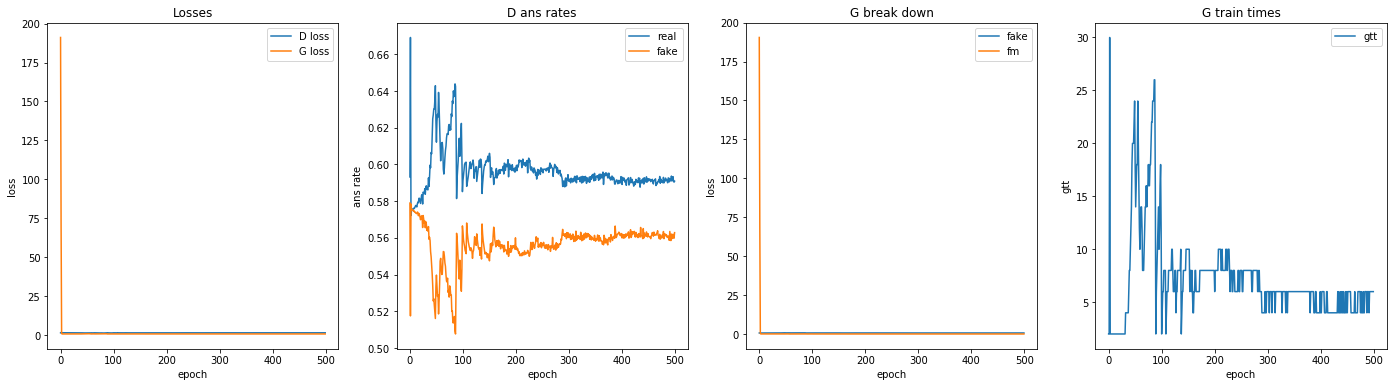

In [17]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=0)

5 images found in ../datasets/theorytab/midinet/learning/midinet2_nosection_test
0: fake_samples_epoch100.png
1: fake_samples_epoch200.png
2: fake_samples_epoch300.png
3: fake_samples_epoch400.png
4: fake_samples_epoch500.png
input the number of image:4


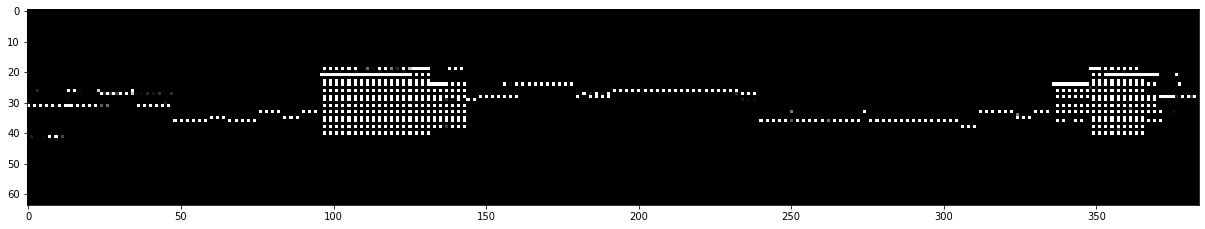

In [22]:
image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
image_paths.sort()

print(f"{len(image_paths)} images found in {save_dir}")
for i, path in enumerate(image_paths):
    print(f"{i}: {path.split('/')[-1]}")

image_path = image_paths[int(input("input the number of image:"))]

img = np.array(Image.open(image_path))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)